<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/2023/lab3/solutions/Lab3_Part_1_Introduction_to_CAPSA.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning/blob/2023/lab3/solutions/Lab3_Part_1_Introduction_to_CAPSA.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [ ]:
# Copyright 2023 MIT Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of MIT Introduction
# to Deep Learning must reference:
#
# © MIT Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Laboratory 3: Debiasing, Uncertainty, and Robustness

# Part 1: Introduction to Capsa

In this lab, we'll explore different ways to make deep learning models more **robust** and **trustworthy**.

To achieve this it is critical to be able to identify and diagnose issues of bias and uncertainty in deep learning models, as we explored in the Facial Detection Lab 2. We need benchmarks that uniformly measure how uncertain a given model is, and we need principled ways of measuring bias and uncertainty. To that end, in this lab, we'll utilize [Capsa](https://github.com/themis-ai/capsa), a risk-estimation wrapping library developed by [Themis AI](https://themisai.io/). Capsa supports the estimation of three different types of ***risk***, defined as measures of how robust and trustworthy our model is. These are:
1. **Representation bias**: reflects how likely combinations of features are to appear in a given dataset. Often, certain combinations of features are severely under-represented in datasets, which means models learn them less well and can thus lead to unwanted bias.
2. **Data uncertainty**: reflects noise in the data, for example when sensors have noisy measurements, classes in datasets have low separations, and generally when very similar inputs lead to drastically different outputs. Also known as *aleatoric* uncertainty. 
3. **Model uncertainty**: captures the areas of our underlying data distribution that the model has not yet learned or has difficulty learning. Areas of high model uncertainty can be due to out-of-distribution (OOD) samples or data that is harder to learn. Also known as *epistemic* uncertainty.

## CAPSA overview

This lab introduces Capsa and its functionalities, to next build automated tools that use Capsa to mitigate the underlying issues of bias and uncertainty.

The core idea behind Capsa is that any deep learning model of interest can be ***wrapped*** -- just like wrapping a gift -- to be made ***aware of its own risks***. Risk is captured in representation bias, data uncertainty, and model uncertainty.

![alt text](https://raw.githubusercontent.com/aamini/introtodeeplearning/2023/lab3/img/capsa_overview.png)

This means that Capsa takes the user's original model as input, and modifies it minimally to create a risk-aware variant while preserving the model's underlying structure and training pipeline. Capsa is a one-line addition to any training workflow in TensorFlow. In this part of the lab, we'll apply Capsa's risk estimation methods to a simple regression problem to further explore the notions of bias and uncertainty. 

Let's get started by installing the necessary dependencies:

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from helper import gen_data_regression

# Download and import the MIT Introduction to Deep Learning package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Download and import Capsa
!pip install capsa
import capsa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1.1 Dataset

We will build understanding of bias and uncertainty by training a neural network for a simple 2D regression task: modeling the function $y = x^3$. We will use `CAPSA` to analyze this dataset and the performance of the model. Noise and missing-ness will be injected into the dataset.

Let's generate the dataset and visualize it:

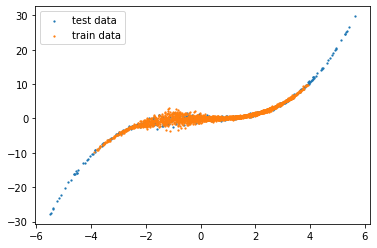

In [ ]:
# Get the data for the cubic function, injected with noise and missing-ness
def gen_data(x_min, x_max, n, train=True):
    x = np.random.triangular(x_min, 2, x_max, size=(n, 1))

    sigma = np.exp(-(x+1)**2/1) + 0.2 if train else np.zeros_like(x)
    y = x**3/6 + np.random.normal(0, sigma).astype(np.float32)

    return x, y

# Plot the dataset and visualize the train and test datapoints
x_train, y_train = gen_data(-4, 4, 2000) # train data
x_test, y_test = gen_data(-6, 6, 500) # test data
plt.scatter(x_train, y_train, s=1.5, label='train data')
plt.scatter(x_test, y_test, s=1.5, label='test data')

plt.legend()
plt.show()

In the plot above, the orange points are the training data, which will be used as inputs to train the neural network model. The blue points are the test data, which will be used to evaluate the performance of the model.

#### **TODO: Inspecting the 2D regression dataset**

 Write short (~1 sentence) answers to the questions below to complete the `TODO`s:

1. What are your observations about where the train data and test data lie relative to each other?
2. What, if any, areas do you expect to have high/low aleatoric (data) uncertainty?
3. What, if any, areas do you expect to have high/low epistemic (model) uncertainty?

## 1.2 Regression on cubic dataset

Next we will define a small dense neural network model that can predict `y` given `x`: this is a classical regression task! We will build the model and use the [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) function to train the model -- normally, without any risk-awareness -- using the train dataset that we visualized above.

In [ ]:
### Define and train a dense NN model for the regression task###

'''Function to define a small dense NN'''
def create_dense_NN():
  return tf.keras.Sequential(
          [
              tf.keras.Input(shape=(1,)),
              tf.keras.layers.Dense(8, "relu"),
              tf.keras.layers.Dense(8, "relu"),
              tf.keras.layers.Dense(1),
          ]
  )

dense_NN = create_dense_NN()

# Build the model for regression, defining the loss function and optimizer
dense_NN.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
  loss=tf.keras.losses.MeanSquaredError(), # MSE loss for the regression task
)

# TODO: Train the model for 30 epochs. Use model.fit().
loss_history = dense_NN.fit(x_train, y_train, epochs=30) 
# loss_history = # TODO

Now, we are ready to evaluate our neural network. We use the test data to assess performance on the regression task, and visualize the predicted values against the true values.

Given your observation of the data in the previous plot, where do you expect the model to perform well? Let's test the model and see:

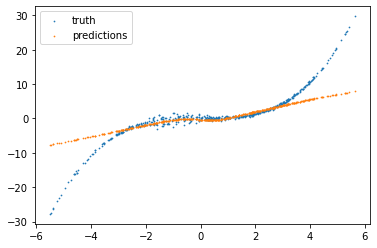

In [ ]:
# Pass the test data through the network and predict the y values
y_predicted = dense_NN(x_test)

# Visualize the true (x, y) pairs for the test data vs. the predicted values
plt.scatter(x_test, y_test, s=0.5, label='truth')
plt.scatter(x_test, y_predicted, s=0.5, label='predictions')
plt.legend()


#### **TODO: Analyzing the performance of standard regression model**

Write short (~1 sentence) answers to the questions below to complete the `TODO`s:

1. Where does the model perform well?
2. Where does the model perform poorly?

## 1.3 Evaluating bias

Now that we've seen what the predictions from this model look like, we will identify and quantify bias and uncertainty in this problem. We first consider bias.

Recall that *representation bias* reflects how likely combinations of features are to appear in a given dataset. Capsa calculates how likely combinations of features are by using a histogram estimation approach: the `capsa.HistogramWrapper`. For low-dimensional data, the `capsa.HistogramWrapper` bins the input directly into discrete categories and measures the density. 

We start by taking our `dense_NN` and wrapping it with the `capsa.HistogramWrapper`:

In [ ]:
### Wrap the dense network for bias estimation ###

standard_dense_NN = create_dense_NN()
bias_wrapped_dense_NN = capsa.HistogramWrapper(
    standard_dense_NN, # the original model
    queue_size=2000, # how many samples to track
    target_hidden_layer=False # for low-dimensional data, we can estimate densities directly from data
  )


Now that we've wrapped the classifier, let's re-train it to update the bias estimates as we train. We can use the exact same training pipeline, using `compile` to build the model and `model.fit()` to train the model:

In [ ]:
### Compile and train the wrapped model! ###

# Build the model for regression, defining the loss function and optimizer
bias_wrapped_dense_NN.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
  loss=tf.keras.losses.MeanSquaredError(), # MSE loss for the regression task
)

# Train the wrapped model for 30 epochs.
loss_history_bias_wrap = bias_wrapped_dense_NN.fit(x_train, y_train, epochs=30)

Epoch 1/30


63/63 [==============================] - 1s 2ms/step - histogram_compiled_loss: 3.9734 - histogram_wrapper_loss: 7.2317
Epoch 2/30
63/63 [==============================] - 0s 2ms/step - histogram_compiled_loss: 2.0948 - histogram_wrapper_loss: 4.1785
Epoch 3/30
63/63 [==============================] - 0s 6ms/step - histogram_compiled_loss: 1.6633 - histogram_wrapper_loss: 3.2580
Epoch 4/30
63/63 [==============================] - 0s 4ms/step - histogram_compiled_loss: 1.5208 - histogram_wrapper_loss: 2.8870
Epoch 5/30
63/63 [==============================] - 0s 4ms/step - histogram_compiled_loss: 1.2064 - histogram_wrapper_loss: 2.5474
Epoch 6/30
63/63 [==============================] - 0s 4ms/step - histogram_compiled_loss: 1.1682 - histogram_wrapper_loss: 2.3297
Epoch 7/30
63/63 [==============================] - 0s 3ms/step - histogram_compiled_loss: 1.0387 - histogram_wrapper_loss: 2.0440
Epoch 8/30
63/63 [==============================] - 0s 3ms/step - histogram_compiled_loss: 0.9

We can now use our wrapped model to assess the bias for a given test input. With the wrapping capability, Capsa neatly allows us to output a *bias score* along with the predicted target value. This bias score reflects the density of data surrounding an input point -- the higher the score, the greater the data representation and density. The wrapped, risk-aware model outputs the predicted target and bias score after it is called!

Let's see how it is done:

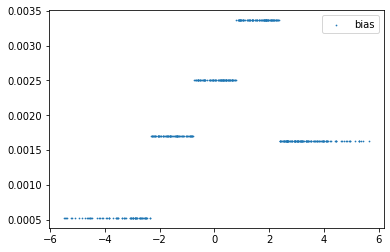

In [ ]:
### Generate and visualize bias scores for data in test set ###

# Call the risk-aware model to generate scores
predictions, bias = bias_wrapped_dense_NN(np.sort(x_test))

# Visualize the relationship between the input data x and the bias
plt.scatter(np.sort(x_test), bias, label='bias', s=0.5)
plt.legend()

#### **TODO: Evaluating bias with wrapped regression model**

Write short (~1 sentence) answers to the questions below to complete the `TODO`s:

1. How does the bias score relate to the train/test data density from the first plot?
2. What is one limitation of the Histogram approach that simply bins the data based on frequency?

# 1.4 Estimating data uncertainty

Next we turn our attention to uncertainty, first focusing on the uncertainty in the data -- the aleatoric uncertainty.

As introduced in Lecture 5 on Robust & Trustworthy Deep Learning, in regression we can estimate aleatoric uncertainty by training the model to predict both a target value and a variance for every input. Because we estimate both a mean and variance for every input, this method is called Mean Variance Estimation (MVE). MVE involves modifying the output layer to predict both the mean and variance, and changing the loss to reflect the prediction likelihood.

Capsa automatically implements these changes for us: we can wrap a given model using `capsa.MVEWrapper` to use MVE to estimate aleatoric uncertainty. All we have to do is define the model and the loss function to evaluate its predictions!

Let's take our standard network, wrap it with `capsa.MVEWrapper`, build the wrapped model, and then train it for the regression task. Finally, we evaluate performance of the resulting model by quantifying the aleatoric uncertainty across the data space: 

In [ ]:
### Estimating data uncertainty with Capsa wrapping ###

standard_dense_NN = create_dense_NN()
# Wrap the dense network for aleatoric uncertainty estimation
mve_wrapped_NN = capsa.MVEWrapper(standard_dense_NN)

# Build the model for regression, defining the loss function and optimizer
mve_wrapped_NN.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
  loss=tf.keras.losses.MeanSquaredError(), # MSE loss for the regression task
)

# Train the wrapped model for 30 epochs.
loss_history_mve_wrap = mve_wrapped_NN.fit(x_train, y_train, epochs=30)

# Call the uncertainty-aware model to generate outputs for the test data
outputs = mve_wrapped_NN(x_test)
# Capsa makes the aleatoric uncertainty an attribute of the prediction!
aleatoric_unc = outputs.aleatoric

# Visualize the aleatoric uncertainty across the data space
plt.scatter(x_test, aleatoric, label='aleatoric uncertainty', s=0.5)
plt.legend()

#### **TODO: Estimating aleatoric uncertainty**

Write short (~1 sentence) answers to the questions below to complete the `TODO`s:

1. For what values of $x$ is the aleatoric uncertainty high or increasing suddenly?
2. How does your answer in (1) relate to how the $x$ values are distributed?

# 1.5 Estimating model uncertainty

Finally, we use Capsa for estimating the uncertainty underlying the model predictions -- the epistemic uncertainty. In this example, we'll use ensembles, which essentially copy the model `N` times and average predictions across all runs for a more robust prediction, and also calculate the variance of the `N` runs to estimate the uncertainty.

Capsa provides a neat wrapper, `capsa.EnsembleWrapper`, to make an ensemble from an input model. Just like with aleatoric estimation, we can take our standard dense network model, wrap it with `capsa.EnsembleWrapper`, build the wrapped model, and then train it for the regression task. Finally, we evaluate the resulting model by quantifying the epistemic uncertainty on the test data:

In [ ]:
### Estimating model uncertainty with Capsa wrapping ###

standard_dense_NN = create_dense_NN()
# Wrap the dense network for epistemic uncertainty estimation with a 5-member Ensemble
ensemble_NN = capsa.EnsembleWrapper(standard_dense_NN, num_members=5)

# Build the model for regression, defining the loss function and optimizer
ensemble_NN.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),
  loss=tf.keras.losses.MeanSquaredError(), # MSE loss for the regression task
)

# Train the wrapped model for 30 epochs.
loss_history_ensemble = ensemble_NN.fit(x_train, y_train, epochs=30)

# Call the uncertainty-aware model to generate outputs for the test data
outputs = ensemble_NN(x_test)
# Capsa makes the epistemic uncertainty an attribute of the prediction!
epistemic_unc = outputs.epistemic

# Visualize the epistemic uncertainty across the data space
plt.scatter(x_test, epistemic, label='epistemic uncertainty', s=0.5)
plt.legend()

Epoch 1/30
63/63 [==============================] - 2s 3ms/step - usermodel_0_compiled_loss: 6.5601 - usermodel_1_compiled_loss: 4.9589 - usermodel_2_compiled_loss: 4.8135 - usermodel_3_compiled_loss: 4.3547 - usermodel_4_compiled_loss: 6.3809
Epoch 2/30
63/63 [==============================] - 0s 3ms/step - usermodel_0_compiled_loss: 3.7732 - usermodel_1_compiled_loss: 4.3968 - usermodel_2_compiled_loss: 2.8938 - usermodel_3_compiled_loss: 3.2580 - usermodel_4_compiled_loss: 4.0894
Epoch 3/30
63/63 [==============================] - 0s 4ms/step - usermodel_0_compiled_loss: 2.8896 - usermodel_1_compiled_loss: 4.1322 - usermodel_2_compiled_loss: 2.3051 - usermodel_3_compiled_loss: 2.6397 - usermodel_4_compiled_loss: 3.0872
Epoch 4/30
63/63 [==============================] - 0s 3ms/step - usermodel_0_compiled_loss: 2.4637 - usermodel_1_compiled_loss: 4.0084 - usermodel_2_compiled_loss: 2.0035 - usermodel_3_compiled_loss: 2.2897 - usermodel_4_compiled_loss: 2.5871
Epoch 5/30
63/63 [======

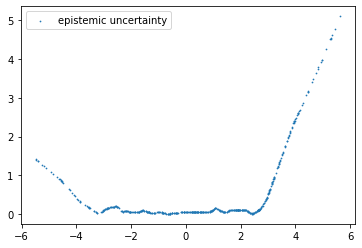

In [ ]:
outputs = ensemble_wrapper(x_val)
plt.scatter(x_val, outputs.epistemic, label='epistemic uncertainty', s=0.5)
plt.legend()

#### **TODO: Estimating epistemic uncertainty**

Write short (~1 sentence) answers to the questions below to complete the `TODO`s:

1. For what values of $x$ is the epistemic uncertainty high or increasing suddenly?
2. How does your answer in (1) relate to how the $x$ values are distributed (refer back to original plot)? Think about both the train and test data.
3. How could you reduce the epistemic uncertainty in regions where it is high?

# 1.6 Conclusion

You've just analyzed the bias, aleatoric uncertainty, and epistemic uncertainty for your first risk-aware model! This is a task that data scientists do constantly to determine methods of improving their models and datasets.

## NOTE TO ADDRESS: THIS CAN BE ELIMINATED COMPLETELY IF IT IS TOO MUCH FOR COMPETITION!
### 1.6.1 Submission information
To be eligible for the Debiasing Faces Lab prize, you must submit a document of your answers to the short-answer `TODO`s with your complete lab submission. **Name your file in the following format: `[FirstName]_[LastName]_Debiasing_Report.pdf`.**

Upload your document write-up as part of your complete lab submission for the Debiasing Faces Lab ([submission upload link](https://www.dropbox.com/request/TTYz3Ikx5wIgOITmm5i2)).

Please see the short-answer `TODO`s replicated again here:

#### **TODO: Inspecting the 2D regression dataset**

1. What are your observations about where the train data and test data lie relative to each other?
2. What, if any, areas do you expect to have high/low aleatoric (data) uncertainty?
3. What, if any, areas do you expect to have high/low epistemic (model) uncertainty?

#### **TODO: Analyzing the performance of standard regression model**

1. Where does the model perform well?
2. Where does the model perform poorly?

#### **TODO: Evaluating bias**

1. How does the bias score relate to the train/test data density from the first plot?
2. What is one limitation of the Histogram approach that simply bins the data based on frequency?

#### **TODO: Estimating aleatoric uncertainty**

1. For what values of $x$ is the aleatoric uncertainty high or increasing suddenly?
2. How does your answer in (1) relate to how the $x$ values are distributed?

#### **TODO: Estimating epistemic uncertainty**

1. For what values of $x$ is the epistemic uncertainty high or increasing suddenly?
2. How does your answer in (1) relate to how the $x$ values are distributed (refer back to original plot)? Think about both the train and test data.
3. How could you reduce the epistemic uncertainty in regions where it is high?

### 1.6.2 Moving forward

In the next part of the lab, you'll continue to build off of these concepts to *mitigate* these risks, in addition to diagnosing them!

![alt text](https://raw.githubusercontent.com/aamini/introtodeeplearning/2023/lab3/img/solutions_toy.png)